#Assignment 4

## Image Retrieval using SIFT

Required Libraries and installations

In [3]:
!pip install --quiet cudf-cu11 cuml-cu11 cupy numpy matplotlib scikit-learn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... canceled
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    stat

In [4]:
import os
import cudf
import time
import joblib
import zipfile
import cv2 as cv
import cupy as cp
import numpy as np
import cuml
from glob import glob
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, vq
from cuml.cluster import KMeans as cuKMeans

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Loading

In [6]:
import zipfile

In [7]:
# Define the path to the ZIP file and extract it
zip_path = "/content/drive/MyDrive/drive-download-20250315T222338Z-001.zip"

extract_folder = "/content/drive/MyDrive/drive-download-20250315T222338Z-001/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extraction completed.")


Extraction completed.


In [8]:
print(os.path.exists(zip_path))

True


In [9]:
# Check extracted folder structure
extracted_files = os.listdir(extract_folder)
print(f"Extracted files and folders: {extracted_files}")


Extracted files and folders: ['cobwebbed', 'crystalline', 'cracked', 'bubbly', 'blotchy', 'crosshatched', 'banded', 'braided', 'bumpy', 'chequered', 'gauzy', 'honeycombed', 'fibrous', 'freckled', 'flecked', 'interlaced', 'grooved', 'frilly', 'dotted', 'grid', 'paisley', 'perforated', 'meshed', 'lacelike', 'pitted', 'marbled', 'pleated', 'lined', 'matted', 'knitted']


In [10]:
image_folder = extract_folder

In [11]:
# List all folders inside the extracted directory
subfolders = os.listdir(extract_folder)
print(f"Extracted subfolders: {subfolders}")

# Now, loop through these subfolders
selected_images = []
for subfolder in subfolders:
    subfolder_path = os.path.join(extract_folder, subfolder)

    if os.path.isdir(subfolder_path):
        images_in_folder = os.listdir(subfolder_path)
        selected_images.extend(images_in_folder)

print(f"Total images found: {len(selected_images)}")


Extracted subfolders: ['cobwebbed', 'crystalline', 'cracked', 'bubbly', 'blotchy', 'crosshatched', 'banded', 'braided', 'bumpy', 'chequered', 'gauzy', 'honeycombed', 'fibrous', 'freckled', 'flecked', 'interlaced', 'grooved', 'frilly', 'dotted', 'grid', 'paisley', 'perforated', 'meshed', 'lacelike', 'pitted', 'marbled', 'pleated', 'lined', 'matted', 'knitted']
Total images found: 3600


Selecting a subset of the dataset

In [12]:
# Load images from all subfolders (
subfolders_to_use = ['honeycombed', 'grid', 'knitted', 'pleated', 'grooved', 'interlaced']
selected_images = []

for subfolder in subfolders_to_use:
    folder_path = os.path.join(extract_folder, subfolder)
    images_in_folder = glob(os.path.join(folder_path, "*.jpg"))
    selected_images.extend(images_in_folder)

print(f"Number of selected images from all folders: {len(selected_images)}")



Number of selected images from all folders: 720


In [13]:
data1 = []
for image_path in selected_images:
    data1.append(cv.imread(image_path, 1))

In [14]:
bw_images = []
for img in data1:
    if len(img.shape) == 3:
        bw_images.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    else:
        bw_images.append(img)

test

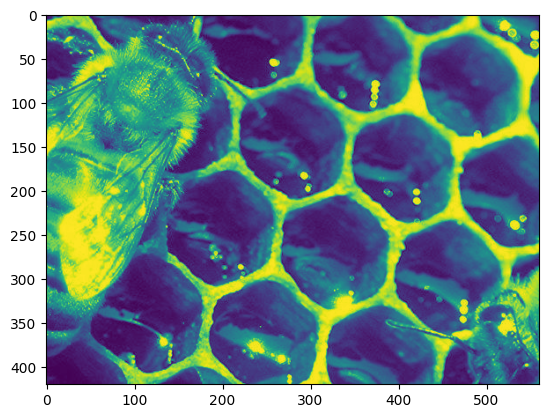

In [15]:
plt.imshow(bw_images[0])

# Extract features using SIFT

In [16]:
extractor = cv.SIFT_create()
keypoints = []
descriptors = []

for img in bw_images:
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

In [17]:
print(len(descriptors))
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    if img_descriptors is None:
        to_drop.append(i)

print(to_drop)
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(len(descriptors))

720
[29, 44, 191, 216, 395, 438, 475, 478, 487, 488, 503, 525, 530, 586]
706


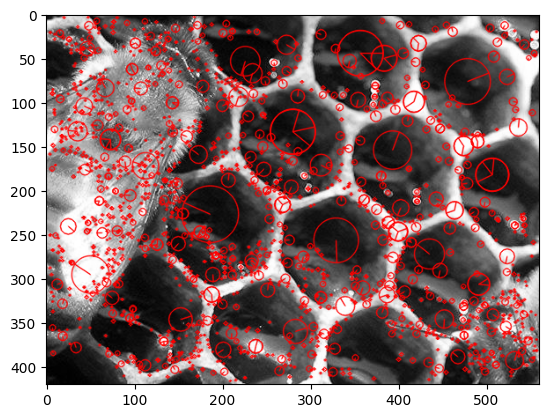

In [19]:
# Display keypoints on the first image
output_image = cv.drawKeypoints(bw_images[0], keypoints[0], None, (255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(output_image)
plt.show()


## Expermient 1: Changing the Number of Images Used to Compute Centroids

function to : efficiently transfers SIFT descriptors to the GPU for faster computations

In [33]:
def SIFT_To_GPU(descriptors):
    valid_descriptors = [desc for desc in descriptors if desc is not None]
    all_descriptors_gpu = np.vstack(valid_descriptors)
    return all_descriptors_gpu  # Ensure return value is assigned

# Call function and store result
all_descriptors_gpu = SIFT_To_GPU(descriptors)  #


In [34]:
all_descriptors_gpu

array([[ 25.,  19.,   4., ...,   0.,   0.,   7.],
       [ 55.,  29.,  35., ...,   0.,   0.,   0.],
       [  0.,   0.,   7., ...,   0.,   0.,   0.],
       ...,
       [ 92.,  35.,  22., ...,   0.,   0.,   6.],
       [  2.,  25., 119., ...,   0.,   0.,   0.],
       [  4.,   4.,  20., ...,   3.,   0.,  20.]], dtype=float32)

perform KMeans clustering with CUML

In [22]:
def Kmeans_with_k(num_centroids, num_images=500):
    descriptors_sample = all_descriptors_gpu[:num_images]
    kmeans = cuKMeans(n_clusters=num_centroids)

    #model
    kmeans.fit(descriptors_sample)
    # Get  centroids
    codebook = kmeans.cluster_centers_.get()

    return codebook

In [23]:
from sklearn.decomposition import PCA

In [38]:
from sklearn.cluster import KMeans

def Kmeans_with_k(num_centroids, num_images):
    descriptors_sample = all_descriptors_gpu[:num_images]
    kmeans = KMeans(n_clusters=num_centroids, random_state=0, n_init=10)
    kmeans.fit(descriptors_sample)
    return kmeans.cluster_centers_


Visualizing Centroid Distribution in Feature Space

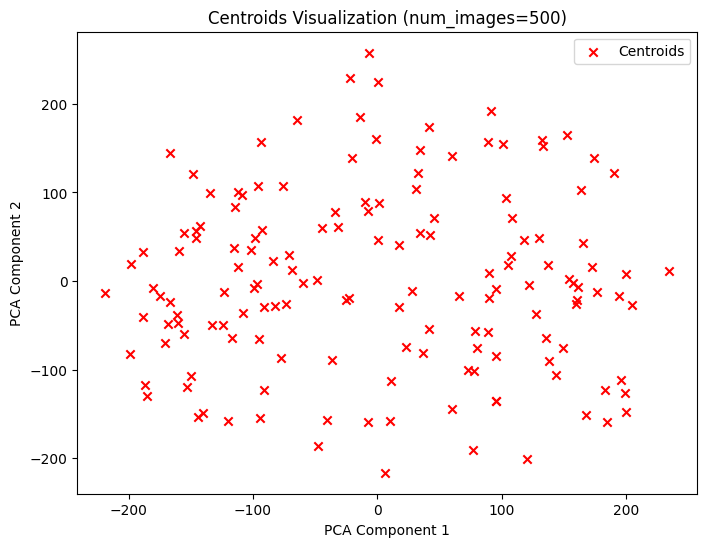

In [39]:
num_centroids = 150
num_images = 500
codebook = Kmeans_with_k(num_centroids=num_centroids, num_images=num_images)
def plot_centroids(codebook, num_images):
    pca = PCA(n_components=2)
    reduced_centroids = pca.fit_transform(codebook)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c='red', marker='x', label='Centroids')
    plt.title(f"Centroids Visualization (num_images={num_images})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

# Call function after generating centroids
plot_centroids(codebook, num_images=500)


## Expermient 2: Changing the Number of Centroids

#### Run KMeans for different centroids (50, 150, 250)

In [ ]:
centroid_options = [50, 150, 250]
codebooks_by_centroids = {}

In [ ]:
for centroids in centroid_options:
    print(f"Running cuML K-means with {centroids} centroids...")
    codebook = Kmeans_with_k(centroids)
    codebooks_by_centroids[centroids] = codebook


Visualizing Centroid Distribution for Different k-values

In [45]:
centroid_options = [50, 150, 250]
num_images = 500

codebooks_by_centroids = {}

Running cuML K-Means with 50 centroids...
Running cuML K-Means with 150 centroids...
Running cuML K-Means with 250 centroids...


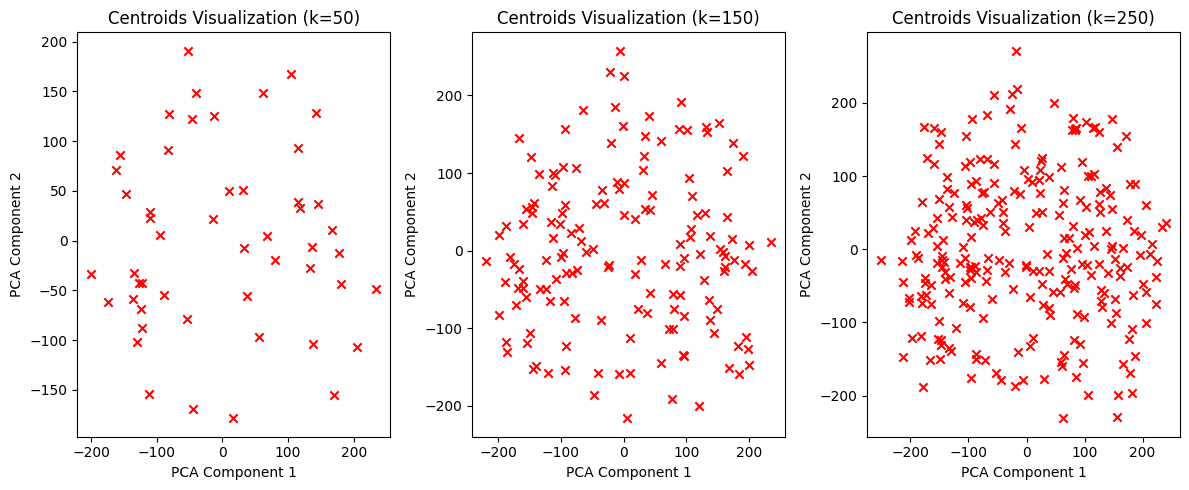

In [46]:
for centroids in centroid_options:
    print(f"Running cuML K-Means with {centroids} centroids...")
    codebook = Kmeans_with_k(num_centroids=centroids, num_images=num_images)
    codebooks_by_centroids[centroids] = codebook

def plot_centroids_for_different_k(codebooks_by_centroids, centroid_options):
    plt.figure(figsize=(12, 5))

    for i, k in enumerate(centroid_options):
        codebook = codebooks_by_centroids[k]  #
        pca = PCA(n_components=2)
        reduced_centroids = pca.fit_transform(codebook)

        plt.subplot(1, len(centroid_options), i+1)
        plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c='red', marker='x')
        plt.title(f"Centroids Visualization (k={k})")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")

    plt.tight_layout()
    plt.show()

# Call visualization function after clustering
plot_centroids_for_different_k(codebooks_by_centroids, centroid_options)


## Expermient 3: Comparing TF-IDF vs. BoW

Compute Bag of Words (BoW) Representation

In [47]:
def compute_bow(visual_words, k=250):
    bow_vectors = np.zeros((len(visual_words), k))
    for i, img_visual_words in enumerate(visual_words):
        for word in img_visual_words:
            bow_vectors[i][word] += 1
    return bow_vectors

visual_words = [vq(img_descriptors, codebooks_by_centroids[250])[0] for img_descriptors in descriptors if img_descriptors is not None]


bow_vectors = compute_bow(visual_words, k=250)
print("BoW representation computed successfully.")


BoW representation computed successfully.


Compute TF-IDF Representation

In [48]:
def compute_tfidf(bow_vectors, k=250):
    N = len(bow_vectors)
    df = np.sum(bow_vectors > 0, axis=0)
    idf = np.log((N + 1) / (df + 1))

    tfidf_vectors = bow_vectors * idf
    return tfidf_vectors

tfidf_vectors = compute_tfidf(bow_vectors, k=250)
print("TF-IDF representation computed successfully.")


TF-IDF representation computed successfully.


Compute Cosine Similarity

Visualizing BoW & TF-IDF Frequency Distributions

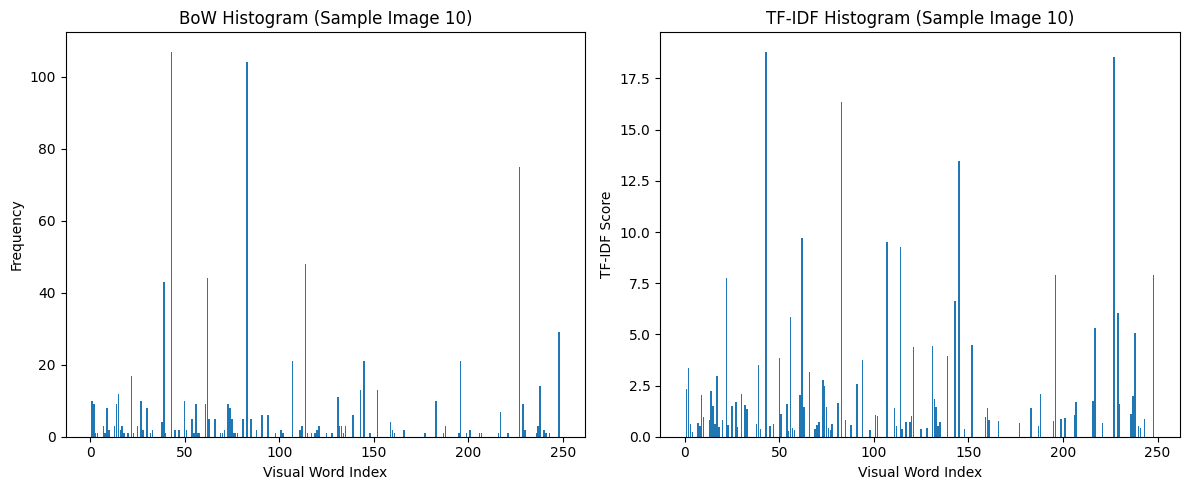

In [58]:
def plot_feature_distribution(bow_vectors, tfidf_vectors, sample_idx=10):
    plt.figure(figsize=(12, 5))

    # Plot BoW distribution
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(len(bow_vectors[sample_idx])), bow_vectors[sample_idx])
    plt.title(f"BoW Histogram (Sample Image {sample_idx})")
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")

    # Plot TF-IDF distribution
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(len(tfidf_vectors[sample_idx])), tfidf_vectors[sample_idx])
    plt.title(f"TF-IDF Histogram (Sample Image {sample_idx})")
    plt.xlabel("Visual Word Index")
    plt.ylabel("TF-IDF Score")

    plt.tight_layout()
    plt.show()

# Call function to visualize distributions
plot_feature_distribution(bow_vectors, tfidf_vectors, sample_idx=10)


In [49]:
from numpy.linalg import norm

In [50]:
def compute_cosine_similarity(matrix):
    similarities = np.dot(matrix, matrix.T) / (norm(matrix, axis=1)[:, None] * norm(matrix, axis=1))
    return similarities

In [51]:
# similarity for BoW and TF-IDF
cosine_similarity_bow = compute_cosine_similarity(bow_vectors)
cosine_similarity_tfidf = compute_cosine_similarity(tfidf_vectors)

print("Cosine similarity computed for BoW and TF-IDF.")


Cosine similarity computed for BoW and TF-IDF.


In [52]:
cosine_similarity_bow

array([[1.        , 0.51315586, 0.20266382, ..., 0.71862228, 0.79283445,
        0.31006328],
       [0.51315586, 1.        , 0.44110027, ..., 0.57962237, 0.65336629,
        0.64463739],
       [0.20266382, 0.44110027, 1.        , ..., 0.24155428, 0.29321422,
        0.31822352],
       ...,
       [0.71862228, 0.57962237, 0.24155428, ..., 1.        , 0.89998324,
        0.54649712],
       [0.79283445, 0.65336629, 0.29321422, ..., 0.89998324, 1.        ,
        0.54555735],
       [0.31006328, 0.64463739, 0.31822352, ..., 0.54649712, 0.54555735,
        1.        ]])

In [53]:
cosine_similarity_tfidf

array([[1.        , 0.53471809, 0.20377474, ..., 0.74780292, 0.79238442,
        0.33377041],
       [0.53471809, 1.        , 0.22747518, ..., 0.50702002, 0.59082096,
        0.52515473],
       [0.20377474, 0.22747518, 1.        , ..., 0.11656316, 0.22416385,
        0.17377116],
       ...,
       [0.74780292, 0.50702002, 0.11656316, ..., 1.        , 0.78126923,
        0.44166357],
       [0.79238442, 0.59082096, 0.22416385, ..., 0.78126923, 1.        ,
        0.46250364],
       [0.33377041, 0.52515473, 0.17377116, ..., 0.44166357, 0.46250364,
        1.        ]])

## **visualization the result**

In [54]:
def visualize_top_k(query_idx, similarity_matrix, method="TF-IDF", top_k=5):
    print(f"\nTop {top_k} retrieved images using {method}:")

    # Get top-K indices
    top_k_idx = np.argsort(-similarity_matrix[query_idx])[:top_k]

    # Display query image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(bw_images[query_idx], cmap='gray')
    plt.title("Query Image")
    plt.axis("off")

    # Display top-K retrieved images
    for i, idx in enumerate(top_k_idx):
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(bw_images[idx], cmap='gray')
        plt.title(f"Rank {i+1}")
        plt.axis("off")

    plt.show()


Top 5 retrieved images using BoW:


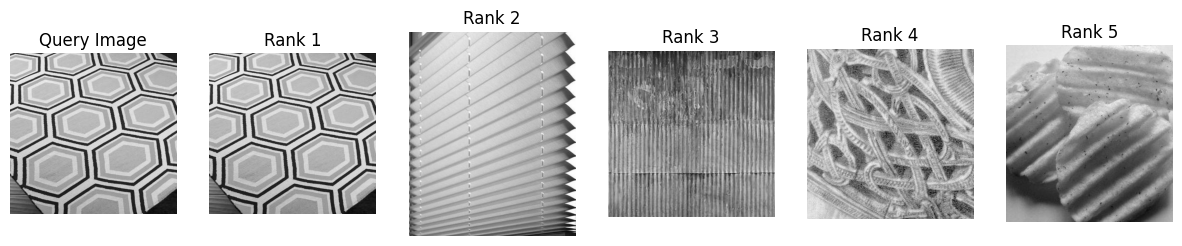


Top 5 retrieved images using TF-IDF:


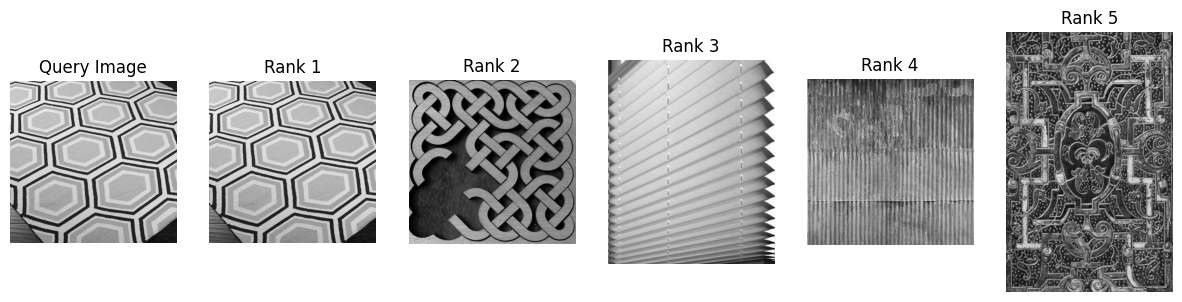

In [55]:
query_idx = 10
visualize_top_k(query_idx, cosine_similarity_bow, method="BoW", top_k=5)
visualize_top_k(query_idx, cosine_similarity_tfidf, method="TF-IDF", top_k=5)

Some Analysis


Top 5 retrieved images using BoW:


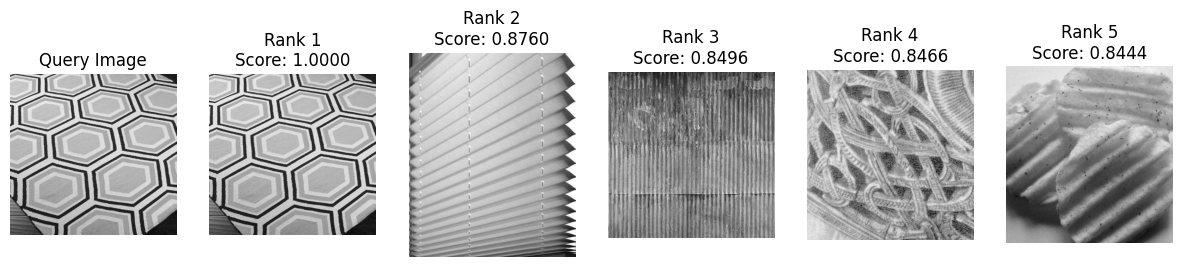


Top 5 retrieved images using TF-IDF:


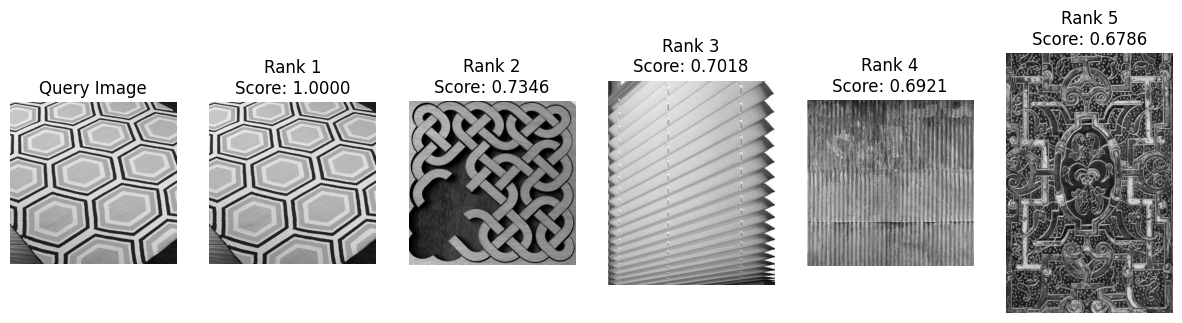

In [56]:
# Function to visualize the top-k retrieved images with similarity scores
def visualize_top_k(query_idx, similarity_matrix, method="TF-IDF", top_k=5):
    print(f"\nTop {top_k} retrieved images using {method}:")

    # Get top-K indices and similarity scores
    top_k_idx = np.argsort(-similarity_matrix[query_idx])[:top_k]
    top_k_scores = similarity_matrix[query_idx][top_k_idx]

    # Display query image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(bw_images[query_idx], cmap='gray')
    plt.title("Query Image")
    plt.axis("off")

    # Display top-K retrieved images with similarity scores
    for i, (idx, score) in enumerate(zip(top_k_idx, top_k_scores)):
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(bw_images[idx], cmap='gray')
        plt.title(f"Rank {i+1}\nScore: {score:.4f}")  # Show similarity score
        plt.axis("off")

    plt.show()

# Test with query image index 10
query_idx = 10
visualize_top_k(query_idx, cosine_similarity_bow, method="BoW", top_k=5)
visualize_top_k(query_idx, cosine_similarity_tfidf, method="TF-IDF", top_k=5)
